# Cosine Similarity

---

- Continue revising: modeling section

### Setup

In [1]:
import os
import time

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-27


### Load Data

In [2]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("..","data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

### BoT

In [7]:
import custom.clean_preprocess as cp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))
                ])

X_counter = pipe['counter'].fit_transform(X_train)
X_bot = pipe['bot'].fit_transform(X_counter)

X_tfidf = pipe.fit_transform(X_train)

### SVD 

In [10]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

def perform_SVD(X, n_components=300):
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T, k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    # return V 
    V = VT.T
    return V

X_svd_bot = perform_SVD(X_bot)
X_svd_tfidf = perform_SVD(X_tfidf)

### Calculate Spam Cosine Similarity

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# no need to transpose as in R
X_cossim_svd_bot = cosine_similarity(X_svd_bot)
X_cossim_svd_tfidf = cosine_similarity(X_svd_tfidf)

# check that it is the 3,900 documents that are being compared, not 300 or 2,000 features
X_cossim_svd_bot.shape, X_cossim_svd_tfidf.shape

((3900, 3900), (3900, 3900))

In [14]:
data = {'sms':X_train, 'target':y_train}
train_df = pd.DataFrame(data)

# get spam indexes
spam_ix = train_df.loc[train_df['target']=='spam'].index

# calculate average spam similarity on SVD
mean_spam_sims_bot, mean_spam_sims_tfidf = [], []
for ix in range(X_cossim_svd_bot.shape[0]):
    mean_spam_sims_bot.append(np.mean(X_cossim_svd_bot[ix, spam_ix]))
    mean_spam_sims_tfidf.append(np.mean(X_cossim_svd_tfidf[ix, spam_ix]))

train_df['mean_spam_cossim_bot'] = mean_spam_sims_bot
train_df['mean_spam_cossim_tfidf'] = mean_spam_sims_tfidf

train_df.head(10)

,sms,target,mean_spam_cossim_bot,mean_spam_cossim_tfidf
0,All sounds good. Fingers . Makes it difficult ...,ham,0.001262,-0.000206
1,Not heard from U4 a while. Call 4 rude chat pr...,spam,0.012506,0.025532
2,"Wishing you and your family Merry \X\"" mas and...",ham,0.003326,-0.000497
3,Yo we are watching a movie on netflix,ham,0.000698,-0.000089
4,Single line with a big meaning::::: \Miss anyt...,ham,0.000740,0.003547
5,Genius what's up. How your brother. Pls send h...,ham,-0.002060,-0.000314
6,Jordan got voted out last nite!,ham,-0.000129,-0.000200
7,Lol yeah at this point I guess not,ham,0.000319,0.000010
8,No..few hours before.went to hair cut .,ham,-0.001041,-0.001098
9,Ok.ok ok..then..whats ur todays plan,ham,-0.000727,-0.001034


### Visualize 

In [27]:
# create a dataframe for plotting
data = {'sims_bot':mean_spam_sims_bot, 
        'sims_tfidf':mean_spam_sims_tfidf, 
        'target':y_train}

spam_sim_df = pd.DataFrame(data)

spam_hist_bot = spam_sim_df.loc[spam_sim_df['target']=='spam']['sims_bot']
ham_hist_bot = spam_sim_df.loc[spam_sim_df['target']=='ham']['sims_bot']
spam_hist_tfidf = spam_sim_df.loc[spam_sim_df['target']=='spam']['sims_tfidf']
ham_hist_tfidf = spam_sim_df.loc[spam_sim_df['target']=='ham']['sims_tfidf']

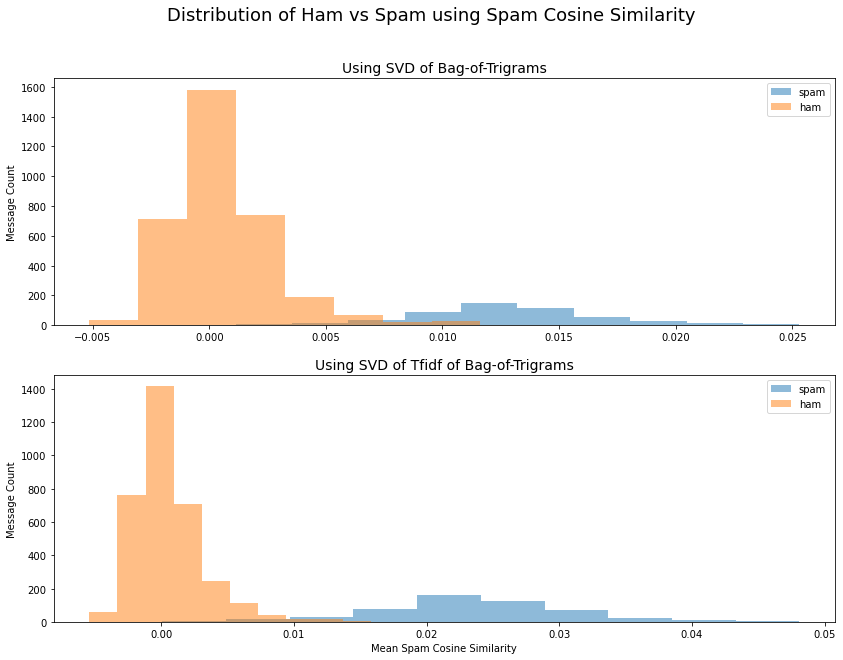

In [48]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(2, figsize=(14, 10))

axs[0].hist(spam_hist_bot, alpha=0.5, label='spam')
axs[0].hist(ham_hist_bot, alpha=0.5, label='ham')
axs[1].hist(spam_hist_tfidf, alpha=0.5, label='spam')
axs[1].hist(ham_hist_tfidf, alpha=0.5, label='ham')

fig.suptitle('Distribution of Ham vs Spam using Spam Cosine Similarity', size=18)
axs[0].set_title('Using SVD of Bag-of-Trigrams', size=14)
axs[1].set_title('Using SVD of Tfidf of Bag-of-Trigrams', size=14)
for ax in axs.flat:
    ax.set(xlabel='', ylabel='Message Count')
    ax.legend()
    
plt.xlabel('Mean Spam Cosine Similarity')    
plt.show()

### Original Tutorial

This looks like a promising feature because average spam cosine similarities seem to separate the target well. Yet we can't rely on visualization alone, we need to run the data through a model to test it out.

The original process was to perform 10-fold CV, repeat 3x, build a random forest model with 500 trees each time, test 7 different values for **mtry**: the number of random variables each tree uses to build itself. 

The best **mtry** value was 52. The accuracy achieved was 97.9%, with a sensitivity (TPR, recall, TP over condition P or $\frac{3365}{(3365+69)}$ below) of 97.99% and specificity (TNR, selectivity, or TN over condition N, or $\frac{454}{(454+13)}$ below) of 97.22%.

```
Confusion Matrix

                Actual
                ham  spam
Predicted ham  3365    13
          spam   69   454
```

This was an improvement on a previous model because the specificity was not as high, meaning, customers would be getting more of their legitimate messages sent to the spam folder, and we can assume that customers more forgiving of the occasional spam not being filtered (lower specificity) rather than losing a legitimate messages (lower specificity).

### Quick Model

# HERE ---- REVISE

In [8]:
# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y = y_train.astype('int')

In [9]:
from scipy.sparse import csr_matrix

X_stacked = sp.hstack((csr_matrix(mean_spam_sims).T, X_train_svd))
X_stacked

<3900x301 sparse matrix of type '<class 'numpy.float64'>'
	with 1173599 stored elements in COOrdinate format>

In [10]:
X_stacked.toarray().shape, y.shape

((3900, 301), (3900,))

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(solver="liblinear", random_state=42)
Xtr, Xte, ytr, yte = train_test_split(X_train_bot, y, test_size=0.25, random_state=42)

log_clf.fit(Xtr, ytr)
ypred = log_clf.predict(Xte)
confusion_matrix(yte, ypred)

array([[834,   0],
       [ 13, 128]], dtype=int64)

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(log_clf, X_train_bot, y, cv=5, verbose=1, scoring='accuracy', n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


0.9848717948717948

In [19]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
acc = cross_val_score(log_clf, X_stacked, y, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
tpr = cross_val_score(log_clf, X_stacked, y, cv=5, verbose=1, scoring='recall', n_jobs=-1)

print(f'accuracy: {acc.mean():0.4f} (+/- {np.std(acc):0.4f})')
print(f'sensitivity: {tpr.mean():0.4f} (+/- {np.std(tpr):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


accuracy: 0.8674 (+/- 0.0006)
sensitivity: 0.0000 (+/- 0.0000)


In [55]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_svd, y, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s


accuracy: 0.8674 (+/- 0.0006)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [58]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, csr_matrix(mean_spam_sims).T, y, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

accuracy: 0.8674 (+/- 0.0006)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [59]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 13 m 2 s


---